In [ ]:
!pip install tensorflow_datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import keras
from keras import layers
from keras.applications import EfficientNetB0, EfficientNetB5
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [ ]:
# Define input image size
input_size = (128, 128, 3)

# Import data

In [ ]:
# Load data
fold_0=pd.read_table('./Folds/original_txt_files/fold_0_data.txt')
fold_1=pd.read_table('./Folds/original_txt_files/fold_1_data.txt')
fold_2=pd.read_table('./Folds/original_txt_files/fold_2_data.txt')
fold_3=pd.read_table('./Folds/original_txt_files/fold_3_data.txt')
fold_4=pd.read_table('./Folds/original_txt_files/fold_4_data.txt')
total_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
total_data = total_data.dropna()
print(fold_0.shape)
print(total_data.shape)

(4484, 12)
(18551, 12)


In [ ]:
# check data
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


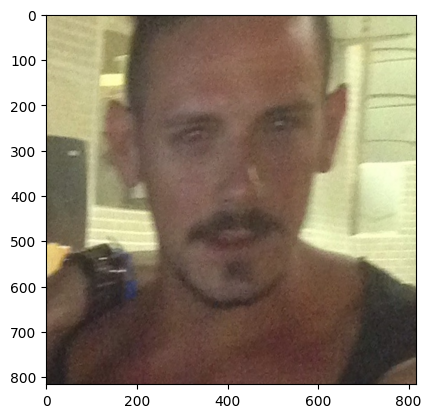

In [ ]:
# Display a sample image from the dataset
path = "./Adience/aligned/"+total_data.user_id.loc[3]+"/landmark_aligned_face."+str(total_data.face_id.loc[3])+"."+total_data.original_image.loc[3]
img = load_img(path)
plt.imshow(img)
plt.show()

# Data Preprocessing

In [ ]:
# Generate image path based on user_id, face_id, and original_image columns
for i in total_data.index:
    total_data.loc[i, 'image_path'] = "./Adience/aligned/" + \
                                       total_data.loc[i, 'user_id'] + \
                                       "/landmark_aligned_face." + \
                                       str(total_data.loc[i, 'face_id']) + \
                                       "." + \
                                       total_data.loc[i, 'original_image']

In [ ]:
# Count the number of each gender category
total_data.gender.value_counts()

gender
f    9332
m    8120
u    1099
Name: count, dtype: int64

In [ ]:
# Filter out irrelevant data
df = total_data[total_data['gender'] != 'u'][['age', 'gender', 'x', 'y', 'dx', 'dy','image_path']]
df.gender.value_counts()

gender
f    9332
m    8120
Name: count, dtype: int64

In [ ]:
# Select relevant features
df = df[['image_path', 'gender']]

In [ ]:
# Check cleaned data
df.head()

,image_path,gender
0,/content/drive/MyDrive/SC4001/new_data/aligned...,f
1,/content/drive/MyDrive/SC4001/new_data/aligned...,m
2,/content/drive/MyDrive/SC4001/new_data/aligned...,f
3,/content/drive/MyDrive/SC4001/new_data/aligned...,m
4,/content/drive/MyDrive/SC4001/new_data/aligned...,m


In [ ]:
# Define a function to preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        # Load and resize the image
        img = load_img(image_path)
        img = img.resize(target_size)

        # Convert image to numpy array
        img_array = np.array(img)

        # Normalize pixel values
        img_array = img_array / 255.0

        return img_array
    except FileNotFoundError:
        return None

In [ ]:
# Preprocess images and filter out records with missing images
df['processed_image'] = df['image_path'].apply(preprocess_image)
df = df.dropna(subset=['processed_image'])

In [ ]:
# Convert processed images to numpy array
X = np.array(df['processed_image'])
# Map gender labels to integers
y = np.array(df['gender'].map({'f': 0, 'm': 1}))

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convert each NumPy array to a TensorFlow tensor
X_train_tf = [tf.convert_to_tensor(arr) for arr in X_train]
X_test_tf = [tf.convert_to_tensor(arr) for arr in X_test]

# Build Models

In [ ]:
# Build model using EfficientNetB5 as backbone
efficient = EfficientNetB5(weights='imagenet',
                           include_top=False,
                           input_shape=input_size)

# Freeze the weights of the EfficientNetB5 backbone
efficient.trainable = False

# Define dropout rate
dr = 0.2

# Build a sequential model
model = Sequential()

# Add EfficientNetB5 as the backbone
model.add(efficient)

# Add GlobalMaxPooling2D layer
model.add(GlobalMaxPooling2D())

# Add Dropout layer with specified dropout rate
if dr > 0:
    model.add(Dropout(dr))

# Add output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Dataset augmentation to improve the generalization of the model
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(np.array(X_train_tf))

In [ ]:
# Setup learning rate scheduler
lr1 = 1e-2
scheduler_1 = ExponentialDecay(lr1, decay_steps=1000, decay_rate=0.96, staircase=True)

In [ ]:
# Compile and train model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=scheduler_1))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 4, 4, 2048)        28513527  
 )                                                               
                                                                 
 global_max_pooling2d_1 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 28515576 (108.78 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 28513527 (108.77 MB)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(np.array(X_train_tf), np.array(y_train), epochs=10, batch_size=16, validation_data=(np.array(X_test_tf), np.array(y_test)))

Epoch 1/10
873/873 [==============================] - 46s 32ms/step - loss: 1.0935 - accuracy: 0.7609 - val_loss: 0.8174 - val_accuracy: 0.8035
Epoch 2/10
873/873 [==============================] - 23s 26ms/step - loss: 1.1763 - accuracy: 0.7752 - val_loss: 0.7993 - val_accuracy: 0.8253
Epoch 3/10
873/873 [==============================] - 23s 26ms/step - loss: 1.2493 - accuracy: 0.7813 - val_loss: 1.3514 - val_accuracy: 0.7683
Epoch 4/10
873/873 [==============================] - 23s 26ms/step - loss: 1.2485 - accuracy: 0.7845 - val_loss: 1.0105 - val_accuracy: 0.7978
Epoch 5/10
873/873 [==============================] - 23s 27ms/step - loss: 1.1982 - accuracy: 0.7868 - val_loss: 0.8587 - val_accuracy: 0.8181
Epoch 6/10
873/873 [==============================] - 23s 26ms/step - loss: 1.2148 - accuracy: 0.7881 - val_loss: 1.0940 - val_accuracy: 0.7983
Epoch 7/10
873/873 [==============================] - 23s 26ms/step - loss: 1.1598 - accuracy: 0.7929 - val_loss: 0.7536 - val_accuracy:

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

110/110 [==============================] - 4s 32ms/step - loss: 0.5633 - accuracy: 0.8253
Test Loss: 0.5632678866386414, Test Accuracy: 0.8252649903297424


In [ ]:
# Build another model using EfficientNetB5 as backbone with trainable weights
efficient2 = EfficientNetB5(weights='imagenet',
                           include_top=False,
                           input_shape=input_size)

# Define a different learning rate
lr2 = 1e-4

# Allow weights of EfficientNetB5 backbone to be trainable
efficient2.trainable = True

# Define dropout rate
dr = 0.2

# Build another sequential model
model2 = Sequential()

# Add EfficientNetB5 as the backbone
model2.add(efficient)

# Add GlobalMaxPooling2D layer
model2.add(GlobalMaxPooling2D())

# Add Dropout layer with specified dropout rate
if dr > 0:
    model2.add(Dropout(dr))

# Add output layer with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model2.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=scheduler_1))

# Display model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 4, 4, 2048)        28513527  
 )                                                               
                                                                 
 global_max_pooling2d_2 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 28515576 (108.78 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 28513527 (108.77 MB)
_________________________________________________________________


In [ ]:
# Train the model
model2.fit(np.array(X_train_tf), np.array(y_train), epochs=10, batch_size=16, validation_data=(np.array(X_test_tf), np.array(y_test)))

Epoch 1/10
873/873 [==============================] - 41s 30ms/step - loss: 1.1035 - accuracy: 0.7613 - val_loss: 0.8183 - val_accuracy: 0.7992
Epoch 2/10
873/873 [==============================] - 23s 26ms/step - loss: 1.2336 - accuracy: 0.7777 - val_loss: 1.1071 - val_accuracy: 0.7757
Epoch 3/10
873/873 [==============================] - 23s 26ms/step - loss: 1.2796 - accuracy: 0.7827 - val_loss: 0.8185 - val_accuracy: 0.8150
Epoch 4/10
873/873 [==============================] - 23s 26ms/step - loss: 1.2515 - accuracy: 0.7840 - val_loss: 1.2585 - val_accuracy: 0.8084
Epoch 5/10
873/873 [==============================] - 23s 26ms/step - loss: 1.1824 - accuracy: 0.7906 - val_loss: 1.8358 - val_accuracy: 0.7362
Epoch 6/10
873/873 [==============================] - 23s 26ms/step - loss: 1.2315 - accuracy: 0.7873 - val_loss: 1.4587 - val_accuracy: 0.7379
Epoch 7/10
873/873 [==============================] - 23s 26ms/step - loss: 1.3270 - accuracy: 0.7817 - val_loss: 1.3479 - val_accuracy:

In [ ]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

110/110 [==============================] - 4s 33ms/step - loss: 0.7653 - accuracy: 0.8287
Test Loss: 0.7652576565742493, Test Accuracy: 0.8287023901939392
